<center><h3>Introduction</h3></center>

Create a neural network to predict taxi fares based upon the day, time and distance.

In [3]:
import pandas as pd
file = '/data/home/rizan.fazily/Neural Networks/EU/taxi-fares.csv'
df = pd.read_csv(file, parse_dates=['pickup_datetime'])

**Transform dataset for analysis**

- Fare
- Get the day of the week (0 - 7)
- Time: 0 - 24
- Distance

Once we have all of the above the dataset is ready for analysis.


In [4]:
from math import sqrt
 
df = df[df['passenger_count'] == 1]
df = df.drop(['key', 'passenger_count'], axis=1)
 
for i, row in df.iterrows():
    dt = row['pickup_datetime']
    df.at[i, 'day_of_week'] = dt.weekday()
    df.at[i, 'pickup_time'] = dt.hour
    x = (row['dropoff_longitude'] - row['pickup_longitude']) * 54.6
    y = (row['dropoff_latitude'] - row['pickup_latitude']) * 69.0
    distance = sqrt(x**2 + y**2)
    df.at[i, 'distance'] = distance
 
df.drop(['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], 
        axis=1, inplace=True)
 
df = df[(df['distance'] > 1.0) & (df['distance'] < 10.0)]
df = df[(df['fare_amount'] > 0.0) & (df['fare_amount'] < 50.0)]
df.head()

,fare_amount,day_of_week,pickup_time,distance
2,6.1,0.0,15.0,1.038136
4,10.5,5.0,10.0,2.924341
5,15.3,4.0,20.0,4.862893
8,7.7,5.0,1.0,2.603493
9,8.9,3.0,16.0,1.365739


**Architecture for the Neural Network**

- 3 input predictors
- 2 hidden layers with 512 neurons in each
- 1 output variables

**Optimizer**
- Adam optimizer algorithm is a combination of RMSProp and Momentum
- Hyperparameters include learning rate, Beta, Epsilon

**Loss Function**
- Mean Absolute Error is the loss function

In [11]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

model = Sequential()

# First hidden layer has 512 neurons and connected to the 3 input dimensions
model.add(Dense(512, activation = 'relu', input_dim = 3))

# Second hidden layer has 512 neurons and connected to the 512 neurons of first hidden layer output
model.add(Dense(512, activation = 'relu'))

# One outer layer connected to 512 outputs of second hidden layer
model.add(Dense(1))

# Set the optimizer and the loss function
model.compile(optimizer = 'adam', loss='mae', metrics =['mae'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               2048      
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 dense_8 (Dense)             (None, 1)                 513       
                                                                 
Total params: 265217 (1.01 MB)
Trainable params: 265217 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Separate the predictors and variables**

In [31]:
x = df.drop('fare_amount', axis = 1)
y = df['fare_amount']

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print('Training samples #:',x_train.shape[0])
print('Testing sample #:',x_test.shape[0])

Training samples #: 18638
Testing sample #: 4660


The batch_size will be 100 for each epoch as 18638 datapoints is too much for each epoch.
75% of the data will be used for training and 30% for testing.

In [32]:
hist = model.fit(x_train,y_train, epochs=100, batch_size=100, validation_split=0.25)

Epoch 1/100
140/140 [==============================] - 0s 3ms/step - loss: 2.2367 - mae: 2.2367 - val_loss: 2.2595 - val_mae: 2.2595
Epoch 2/100
140/140 [==============================] - 0s 3ms/step - loss: 2.2351 - mae: 2.2351 - val_loss: 2.2522 - val_mae: 2.2522
Epoch 3/100
140/140 [==============================] - 0s 3ms/step - loss: 2.2359 - mae: 2.2359 - val_loss: 2.2510 - val_mae: 2.2510
Epoch 4/100
140/140 [==============================] - 0s 3ms/step - loss: 2.2341 - mae: 2.2341 - val_loss: 2.2603 - val_mae: 2.2603
Epoch 5/100
140/140 [==============================] - 0s 3ms/step - loss: 2.2357 - mae: 2.2357 - val_loss: 2.2479 - val_mae: 2.2479
Epoch 6/100
140/140 [==============================] - 0s 3ms/step - loss: 2.2408 - mae: 2.2408 - val_loss: 2.2517 - val_mae: 2.2517
Epoch 7/100
140/140 [==============================] - 0s 3ms/step - loss: 2.2354 - mae: 2.2354 - val_loss: 2.2553 - val_mae: 2.2553
Epoch 8/100
140/140 [==============================] - 0s 3ms/step - 

**Plot the training loss and the validation loss against the epoch counts**

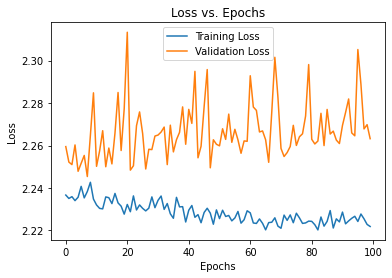

In [33]:
import matplotlib.pyplot as plt

# Extract the loss and validation loss
loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Plot the training and validation loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.show()

**Observations**

- Training error is ~ 2.30 which means this model can predict the fares within $2.30 of the actual fare.**

**Get the R2 Score**

- For how accurate a prediction is

In [36]:
from sklearn.metrics import r2_score
R2= round(r2_score(y_test, model.predict(x_test)),3)
print('R2:',R2)

146/146 [==============================] - 0s 490us/step
R2: 0.729


**Model Check**

Predict for a taxi ride with the following conditions:
- Sunday
- Noon
- 10 miles

In [52]:
predicted_price = model.predict([[0, 12, 10]])  
print('Expected price:', round(predicted_price[0][0], 3))

1/1 [==============================] - 0s 25ms/step
Expected price: 34.893
